# CT Scan plots

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

In [494]:
ct_path = PROJECT_ROOT / 'additional_data' / 'CT_scan'
vivek_ct = "vivek_volume.nii.gz"

vivek_ct_img = nib.load(str(ct_path / vivek_ct))
vivek_ct_vol = vivek_ct_img.get_fdata(dtype=np.float32)
vivek_ct_affine = vivek_ct_img.affine

In [ ]:
print(vivek_ct_img.header)
# print(np.min(noe_ct_vol), np.max(noe_ct_vol), np.mean(noe_ct_vol))
Z_vivek = 1000 * (1540 + 0.35 * vivek_ct_vol) + vivek_ct_vol * (1540 + 0.35 * vivek_ct_vol)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 201 201 239   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 0.  0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -150.70508
qoffset_y       : 4.294922
q

# Brain, Noé DICOM file conveted to NIfTI

In [6]:
opening_angle = 0.9157579425453843

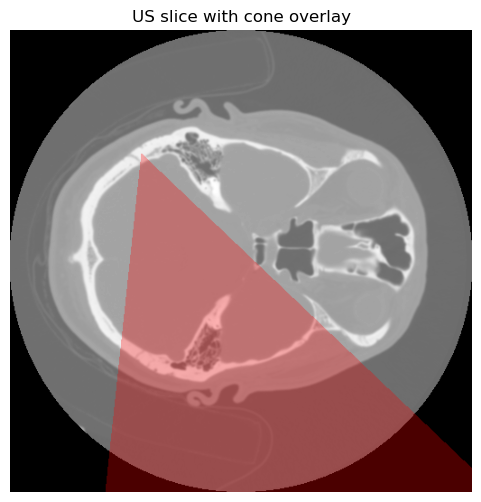

In [ ]:
slice = 100
x0, y0 = 140, 360
direction_vec_2d = direction_vec = np.array([ 0.34467694, -0.93872137])
mask_ct = overlay_cone(noe_ct_vol[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
plot_overlay_cone(noe_ct_vol[:,:,slice], mask_ct)

In [ ]:
start = 0
n_rays = 64
dx, dy = direction_vec_2d
direction_vec = np.array([dx, dy, slice])
source = np.array([x0, y0, slice])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)


In [ ]:
# Z = (1000 + noe_ct_vol ) * 1540
Z_noe = 1000 * (1540 + 0.35 * noe_ct_vol) + noe_ct_vol * (1540 + 0.35 * noe_ct_vol)

In [ ]:
renderer = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)
x,z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_noe),
            source=torch.tensor(source),
            directions=torch.tensor(directions),
            angle=0,
            plot=False,
            artifacts=False,
            start=start
        )

C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\1497929538.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([140, 360, 100], dtype=torch.int32) and directions shape: torch.Size([64, 1, 3])


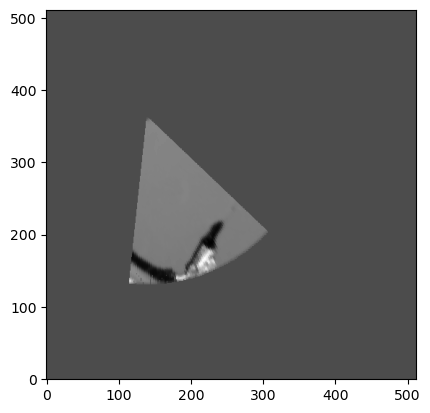

In [92]:
H, W = noe_ct_vol[:,:,slice].shape[:2]
synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

# Chest, vivek volume

Text(0.5, 1.0, 'CT Volume Slice 15 (Shape: (201, 201, 239))')

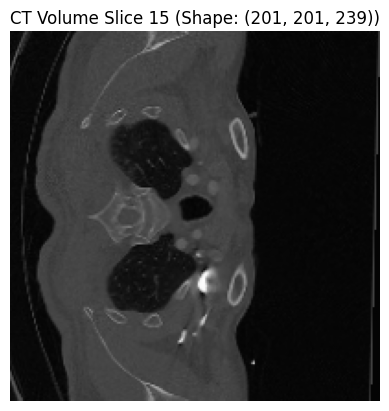

In [499]:
plt.imshow(vivek_ct_vol[:,:,35], cmap='gray', origin="lower")
plt.axis('off')
plt.title("CT Volume Slice {} (Shape: {})".format(slice, vivek_ct_vol.shape))

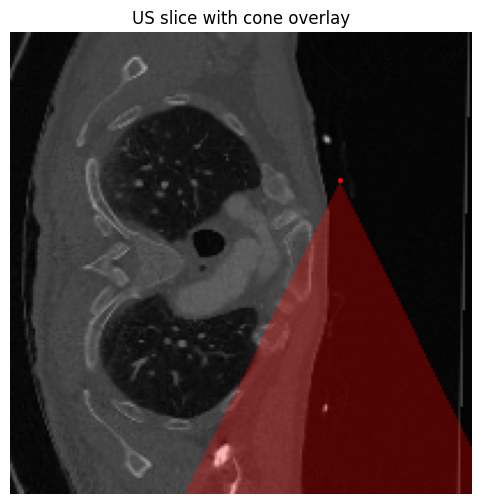

In [500]:
slice = 15
x0, y0 = 136,143
direction_vec_2d = np.array([ -1, 0])
mask_ct = overlay_cone(vivek_ct_vol[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
plot_overlay_cone(vivek_ct_vol[:,:,slice], mask_ct)
plt.plot(y0, x0, 'r.', markersize=5)

# Front view

C:\Users\noe\AppData\Local\Temp\ipykernel_36396\2573211151.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([143,  15,  15]) and directions shape: torch.Size([200, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=278.7804, y=240.6868, z=0.0000


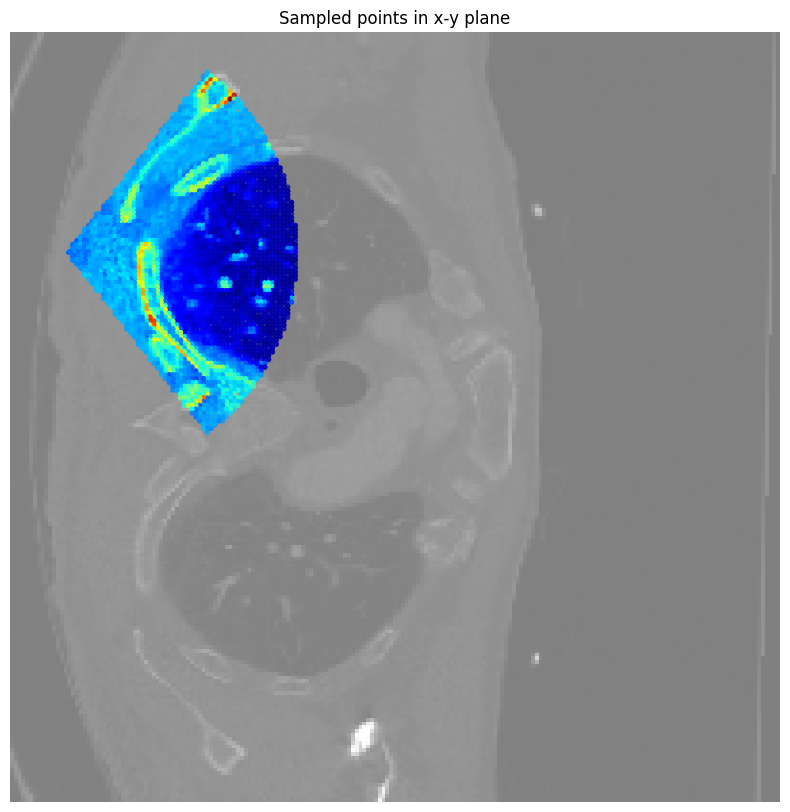

[INFO] Ray values shape: torch.Size([200, 60])
[INFO] Starting from sample index: 10 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 10 torch.Size([200, 61])
[INFO] Variances: [0.0, 333.16790771484375, 175.60093688964844]
tensor(-1.7973) tensor(3.6091) tensor(0.0794)


(np.float64(-0.5), np.float64(200.5), np.float64(-0.5), np.float64(200.5))

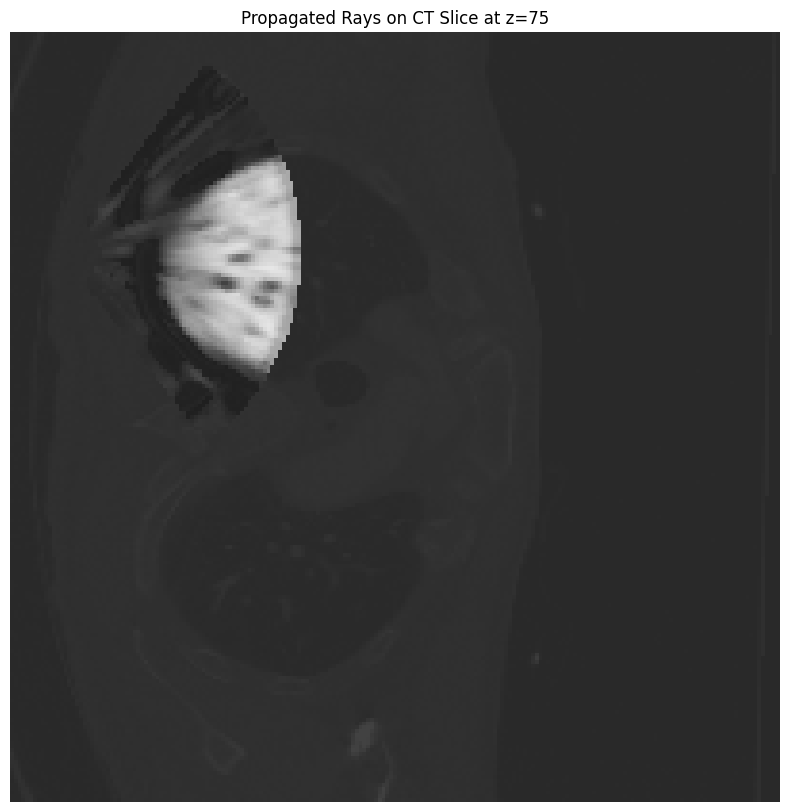

In [ ]:
start = 0
n_rays = 200
dx, dy = direction_vec_2d
direction_vec = np.array([0,1, slice])
source = np.array([y0, 15, slice])
directions = generate_cone_directions(direction_vec, 2*opening_angle, n_rays)
renderer = UltrasoundRenderer(num_samples=60, attenuation_coeff=0.0001)
x,y, z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek),
            source=torch.tensor(source),
            directions=torch.tensor(directions),
            angle=25,
            plot=False,
            artifacts=False,
            start=10
        )

H, W = vivek_ct_vol[:,:,slice].shape[:2]
plt.figure(figsize=(10,10))
plt.imshow(vivek_ct_vol[:,:,slice], cmap='gray', origin="lower", alpha=0.5)
synth_img = differentiable_splat(z,x,y, intensities[:,:-1], H=H, W=W, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img, cmap='gray', origin="lower", alpha=0.8, vmin=-0.3)
plt.title("Propagated Rays on CT Slice")
plt.axis('off')


(np.float64(-0.5), np.float64(238.5), np.float64(-0.5), np.float64(200.5))

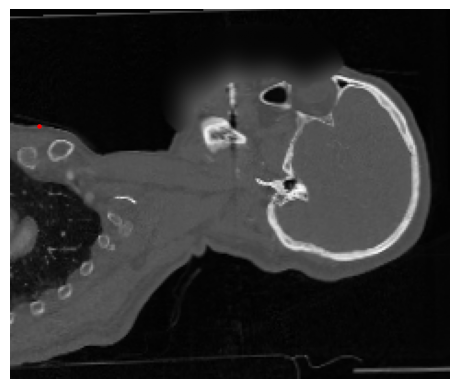

In [566]:
plt.imshow(vivek_ct_vol[75,:,:], cmap='gray', origin="lower")
source = np.array([75, 15, 137])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)
directions = directions[:, [2, 1,0]]
directions[:,1] = -directions[:,1]  # flip y-axis for correct orientation
plt.scatter(source[1], source[2], c='r', s=5)
plt.axis('off')


# Side view

C:\Users\noe\AppData\Local\Temp\ipykernel_36396\1488835147.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([ 75, 140,  12]) and directions shape: torch.Size([200, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=0.0000, y=778.6596, z=145.6897


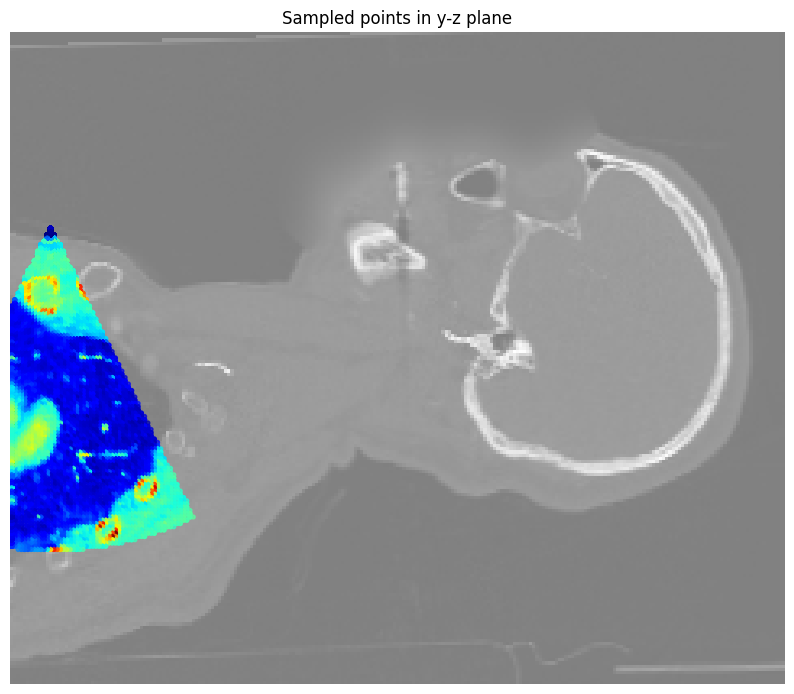

[INFO] Ray values shape: torch.Size([200, 100])
[INFO] Starting from sample index: 15 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 15 torch.Size([200, 101])


In [573]:
renderer = UltrasoundRenderer(num_samples=100, attenuation_coeff=0.0001)
x,y, z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek),
            source=torch.tensor([75, 140,12]),
            directions=torch.tensor(directions),
            angle=20,
            plot=False,
            artifacts=False,
            start=15
        )

(np.float64(-0.5), np.float64(238.5), np.float64(-0.5), np.float64(200.5))

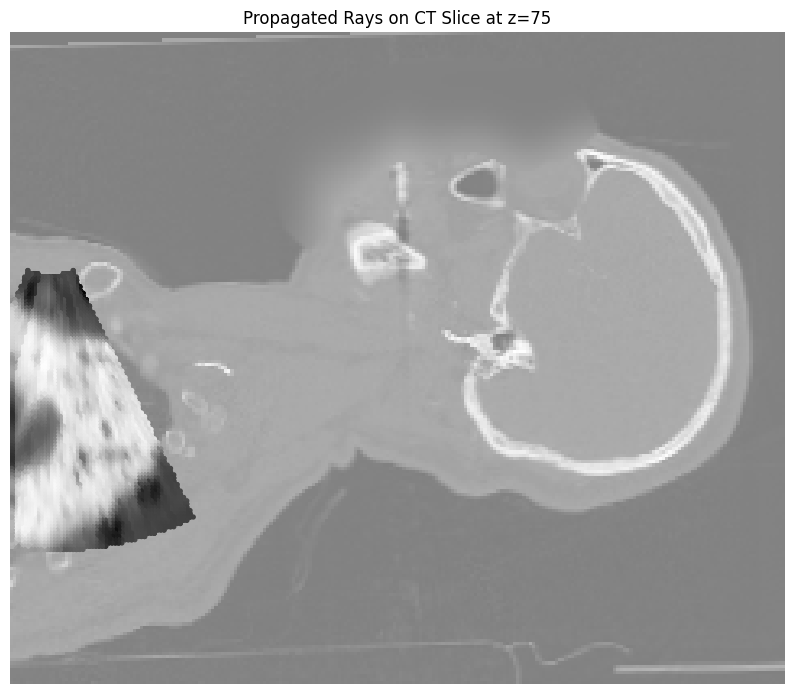

In [574]:
plt.figure(figsize=(10,10))
plt.imshow(vivek_ct_vol[75,:,:], cmap='gray', origin="lower", alpha=0.5)
plt.scatter(z, y, c=intensities[:,:-1], s=8, cmap='gray', alpha=1)
plt.title("Propagated Rays on CT Slice at z=75")
plt.axis('off')

# Third view

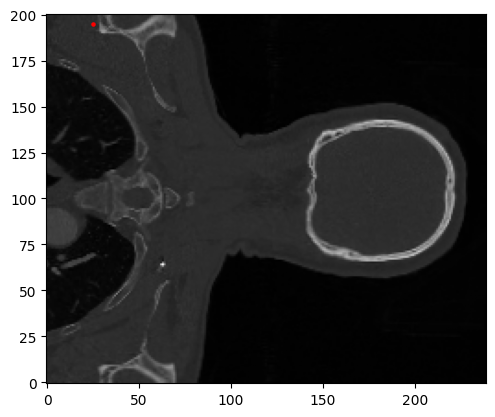

In [ ]:
plt.imshow(Z_vivek[:,75,:], cmap='gray', origin="lower")
source = np.array([25, 75, 195])
plt.scatter(source[0], source[2], c='r', s=5)

In [661]:
directions_2

tensor([[ 0.7930,  0.0000, -0.6092],
        [ 0.7874,  0.0000, -0.6165],
        [ 0.7817,  0.0000, -0.6237],
        [ 0.7759,  0.0000, -0.6309],
        [ 0.7701,  0.0000, -0.6380],
        [ 0.7642,  0.0000, -0.6450],
        [ 0.7582,  0.0000, -0.6520],
        [ 0.7522,  0.0000, -0.6590],
        [ 0.7461,  0.0000, -0.6659],
        [ 0.7399,  0.0000, -0.6727],
        [ 0.7337,  0.0000, -0.6795],
        [ 0.7274,  0.0000, -0.6862],
        [ 0.7210,  0.0000, -0.6929],
        [ 0.7146,  0.0000, -0.6995],
        [ 0.7082,  0.0000, -0.7060],
        [ 0.7016,  0.0000, -0.7125],
        [ 0.6951,  0.0000, -0.7190],
        [ 0.6884,  0.0000, -0.7253],
        [ 0.6817,  0.0000, -0.7316],
        [ 0.6749,  0.0000, -0.7379],
        [ 0.6681,  0.0000, -0.7440],
        [ 0.6612,  0.0000, -0.7502],
        [ 0.6543,  0.0000, -0.7562],
        [ 0.6473,  0.0000, -0.7622],
        [ 0.6403,  0.0000, -0.7681],
        [ 0.6332,  0.0000, -0.7740],
        [ 0.6260,  0.0000, -0.7798],
 

In [666]:
directions_2 = directions[:,[1,2,0]]
directions_2[:,0] = -directions_2[:,0]  # flip x-axis for correct orientation

C:\Users\noe\AppData\Local\Temp\ipykernel_36396\1955411125.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([195,  75,  25]) and directions shape: torch.Size([200, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=240.6868, y=0.0000, z=243.1682


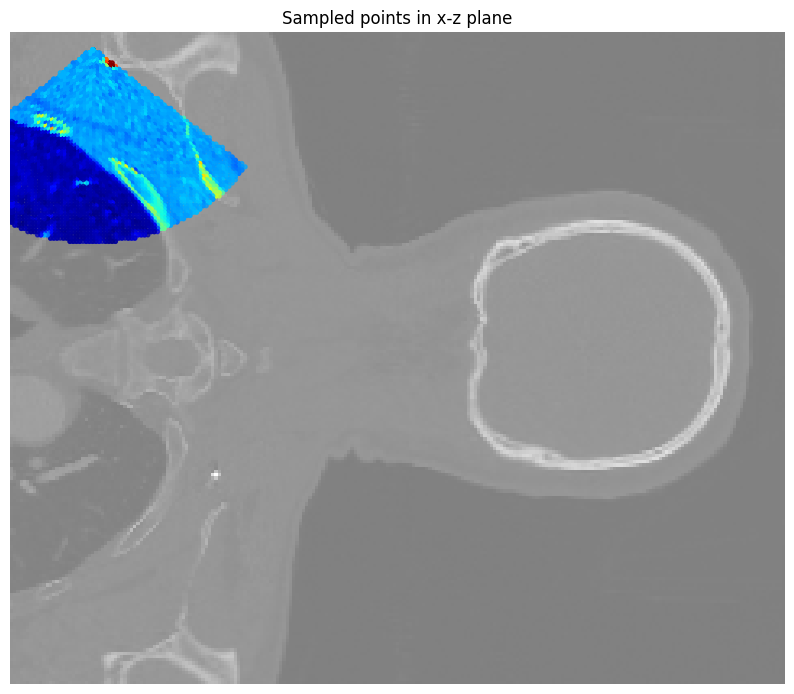

[INFO] Ray values shape: torch.Size([200, 60])
[INFO] Starting from sample index: 10 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 10 torch.Size([200, 61])


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [669]:
start = 0
n_rays = 200
dx, dy = direction_vec_2d
direction_vec = np.array([0,1, slice])
source = np.array([195, 75, 25])
renderer = UltrasoundRenderer(num_samples=60, attenuation_coeff=0.0001)
x,y, z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek),
            source=torch.tensor(source),
            directions=torch.tensor(directions_2),
            angle=25,
            plot=False,
            artifacts=False,
            start=10
        )

H, W = vivek_ct_vol[:,:,slice].shape[:2]
plt.figure(figsize=(10,10))

[INFO] Variances: [175.60093688964844, 0.0, 290.3526306152344]
tensor(-1.5101) tensor(3.7241) tensor(0.0840)


(np.float64(-0.5), np.float64(200.5), np.float64(-0.5), np.float64(200.5))

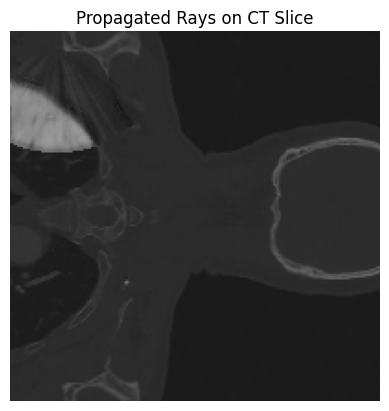

In [688]:
plt.imshow(Z_vivek[:,75,:], cmap='gray', origin="lower", alpha=1)
synth_img = differentiable_splat(x,y,z, intensities[:,:-1], H=H, W=W, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img.T, cmap='gray', origin="lower", alpha=0.6, vmin=-0.8)
plt.title("Propagated Rays on CT Slice")
plt.axis('off')
